In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
classes = [
    
    'square',
    'triangle',
    'star',
    'car',
    'apple',
    'dog',
    'cat',
    'dragon',
    'frog',
    'banana',
    'carrot',
    'dumbbell',
    'ice_cream',
    'baseball',
    'bicycle',
    'cannon',
    'airplane',
    'flip_flops'
    
]

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [8]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/square.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/triangle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/car.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dragon.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/frog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/carrot.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ice%20c

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [47]:
x_train, y_train, x_test, y_test, class_names = load_data('data',max_items_per_class=20000)
num_classes = len(class_names)
image_size = 28
print(len(x_train))

288000


banana


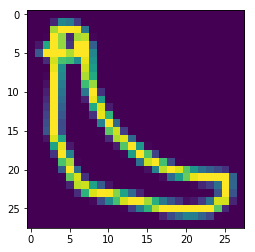

In [48]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [50]:
print(x_train.shape)

(288000, 28, 28, 1)


In [51]:
model = Sequential()

model.add(Conv2D(16, (3, 3),padding='same', input_shape=x_train.shape[1:],activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 64)        

In [52]:
model.fit(x = x_train, y = y_train, validation_split=0.2, batch_size = 50, verbose=1, epochs=30)

Train on 230400 samples, validate on 57600 samples
Epoch 1/30
230400/230400 [==============================] - 137s 595us/step - loss: 0.7598 - acc: 0.7791 - val_loss: 0.4850 - val_acc: 0.8554
Epoch 2/30
230400/230400 [==============================] - 139s 602us/step - loss: 0.4936 - acc: 0.8587 - val_loss: 0.3949 - val_acc: 0.8832
Epoch 3/30
230400/230400 [==============================] - 137s 594us/step - loss: 0.4339 - acc: 0.8745 - val_loss: 0.3770 - val_acc: 0.8878
Epoch 4/30
230400/230400 [==============================] - 134s 582us/step - loss: 0.3984 - acc: 0.8844 - val_loss: 0.3579 - val_acc: 0.8947
Epoch 5/30
230400/230400 [==============================] - 137s 594us/step - loss: 0.3767 - acc: 0.8906 - val_loss: 0.3642 - val_acc: 0.8928
Epoch 6/30
230400/230400 [==============================] - 137s 593us/step - loss: 0.3592 - acc: 0.8944 - val_loss: 0.3554 - val_acc: 0.8960
Epoch 7/30
230400/230400 [==============================] - 136s 591us/step - loss: 0.3454 - acc:

In [57]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 89.98%


In [58]:

# 2. Save Keras Model or weights on google drive

accuracy = "89_98"
# create on Colab directory
model.save_weights('thinkndraw_'+accuracy+'.h5')
model_file = drive.CreateFile({'title' : 'thinkndraw_'+accuracy+'.h5'})
model_file.SetContentFile('thinkndraw_'+accuracy+'.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

model.save('thinkndraw_'+accuracy+'.model')
model_file = drive.CreateFile({'title' : 'thinkndraw_'+accuracy+'.model'})
model_file.SetContentFile('thinkndraw_'+accuracy+'.model')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1a_xXZQE4vI92emjv3_1TtKu1dqJRzaoi'})